# utils

> This module includes utility functions that are used across multiple modules, such as coordinate transformations, interpolation functions, and statistical analysis tools.

In [ ]:
#| default_exp utils

In [ ]:
#| hide
from nbdev.showdoc import *

In [68]:
#| export
from LensCalcPy.parameters import *
import numpy as np
from numpy import pi
from scipy.integrate import quad, nquad
from scipy.optimize import brentq
from pathos.multiprocessing import ProcessingPool as Pool
from scipy.interpolate import interp2d
import pickle
from LensCalcPy.interpolations.interps import ut_interp

import matplotlib.pyplot as plt

from fastcore.test import *

In [69]:
#| export

#Put 0 indent assignments so that variables will be in __all__
ut_interp = ut_interp

In [109]:
#| export

def dist_mw(d: float, # distance from the Sun in kpc
            ) -> float: #distance to the MW center in kpc
    return np.sqrt(d**2 + rEarth**2 - 2*d*rEarth*np.cos(np.radians(l))*np.cos(np.radians(b)))

def dist_m31(d: float, # distance from the Sun in kpc
             ) -> float: #distance to the M31 center in kpc
            return dsM31 - d

def density_mw(r: float, # distance to MW center in kpc
                ) -> float: # DM density in Msun/kpc^3
    return rhoc / ((r/rs) * (1 + r/rs)**2)

def density_m31(r: float, # distance to M31 center in kpc
                ) -> float: # DM density in Msun/kpc^3
    return rhocM31 / ((r/rsM31) * (1 + r/rsM31)**2)

def mass_enclosed_mw(r: float  # distance to MW center in kpc
                      ) -> float : # enclosed DM mass in Msun
    return 4*pi * rhoc * rs**3 * (np.log(1 + r/rs) - (r/rs)/(1 + r/rs))

def mass_enclosed_m31(r: float  # distance to M31 center in kpc
                        ) -> float : # enclosed DM mass in Msun
    return 4*pi * rhocM31 * rsM31**3 * (np.log(1 + r/rsM31) - (r/rsM31)/(1 + r/rsM31))

def velocity_dispersion_mw(r: float, # distance from the MW center in kpc
                        ) -> float: # velocity dispersion in km/s
    if r == 0:
        return 0
    return np.sqrt(G * mass_enclosed_mw(r) / r) 

def velocity_dispersion_m31(r: float, # distance from the M31 center in kpc
                        ) -> float: # velocity dispersion in km/s
    if r == 0:
        return 0
    return np.sqrt(G * mass_enclosed_m31(r) / r)

def dist(d: float # distance from the Sun in kpc
         ) -> float: #weighted lensing distance in kpc
    return d * (1 - d/ds)

def einstein_rad(d: float, # distance from the Sun in kpc
                 mass: float, # mass of the lens in Msun
                 ) -> float:
    return (4 * G * mass * dist(d)/c**2)**(1/2)

def velocity_radial(d: float, # distance from the Sun in kpc
                    mass: float, # mass of the lens in Msun
                    umin: float, # minimum impact parameter
                    t: float, # crossing time in hours
                    ut: float, # threshold impact parameter
                    ) -> float: # radial velocity in km/s
    return 2*einstein_rad(d, mass) * (ut**2 - umin**2)**(1/2) / t * kpctokm

# from below 16 of https://iopscience.iop.org/article/10.3847/1538-4357/ac07a8/pdf*)
# alphabar = 27 Degrees xp-axis is aligned with the major axis
# of the Galactic bar,where \[Alpha]bar=27\[Degree] is applied as the bar angle.
# galactocentric coordniates x', y', z' as function of d, distance from Sun

def get_primed_coords(d: float, # distance from Sun in km
                      l: float = l, # galactic longitude in degrees
                      b: float = b, # galactic latitude in degrees
                      )-> tuple:
    """Get galactocentric coordinates x', y' given galactic latitude and longitude l, b, and distance d
    """
    # convert angles from degrees to radians
    l_rad = np.deg2rad(l)
    b_rad = np.deg2rad(b)
    alpha_rad = np.deg2rad(alphabar)

    # calculate unrotated Cartesian coordinates
    x_unrot = rEarth - d * np.cos(b_rad) * np.cos(l_rad)
    y_unrot = d * np.cos(b_rad) * np.sin(l_rad)

    # rotate the coordinates
    x_prime = x_unrot * np.cos(alpha_rad) - y_unrot * np.sin(alpha_rad)
    y_prime = x_unrot * np.sin(alpha_rad) + y_unrot * np.cos(alpha_rad)

    z_prime = d * np.sin(b_rad)

    return x_prime, y_prime, z_prime

def scientific_format(x, pos):
    """
    Formats a number in scientific notation in latex
    """
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [112]:
#sanity checks
test_eq(mass_enclosed_m31(0), 0)
test_eq(mass_enclosed_mw(0), 0)
test_eq(velocity_dispersion_m31(0), 0)
test_eq(velocity_dispersion_mw(0), 0)

In [95]:
#test that galactic center is at (0, 0, 0) for l=b=0
test_eq(get_primed_coords(rEarth, 0, 0), (0, 0, 0))

#test that earth's distance from galactic center is rEarth, even in primed coordinates
test_close(np.sum(np.array(get_primed_coords(0))**2)**(1/2), rEarth)

#test eq.4 of appendix in https://arxiv.org/pdf/1701.02151.pdf
test_close(einstein_rad(100, 1e-8)*(3600 * 180 / np.pi)/100, 3e-8, eps=1e-8)

In [114]:
#| export
# Add finite size calculation following https://arxiv.org/pdf/1905.06066.pdf

# Compute 'w' parameter given the mass of the primordial black hole and the wavelength
def w_func(m_pbh, lam):
    return 5.98 * (m_pbh / 1e-10) * (lam / 6210)**(-1)

# Compute 'rho' parameter given the mass of the primordial black hole and the lens distance
def rho_func(m_pbh, dl, ds):
    if dl >= ds:
        raise ValueError("dl must be less than ds to prevent division by zero.")
    if dl == 0:
        return 1e-2
    x = dl / ds
    return 5.9 * (m_pbh / 1e-10)**(-1/2) * (x / (1-x))**(1/2)

# Compute magnification given the impact parameter 'u'
def magnification(u):
        if u == 0:
            return np.inf
        else:
            return (u**2 + 2) / (u * (u**2 + 4)**0.5)

# Compute magnification in the wave optics regime
def magnification_wave(w, u):
    # Note this is taking the maximum value of the wave optics magnification
    # In reality, need to evaluate the hypergeometric function
    return np.minimum(magnification(u), np.pi * w / (1 - np.exp(-np.pi * w)))

# Compute displacement given 'x', 'y', and 'u'
def displacement(x, y, u):
    return ((x - u)**2 + y**2)**0.5

# Compute integrand in polar coordinates
def integrand_polar_wave(r, theta, w, u):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return magnification_wave(w, displacement(x, y, u)) * r

def integrand_polar(r, theta, w, u):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return magnification(displacement(x, y, u)) * r

# Compute finite magnification
def magnification_finite_wave(m_pbh, lam, u, dl, ds):
    w = w_func(m_pbh, lam)
    rho = rho_func(m_pbh, dl, ds)
    integrand = lambda r, theta: integrand_polar_wave(r, theta, w, u)
    result, _ = nquad(integrand, [[0, rho], [0, 2 * pi]])
    return result / (pi * rho**2)

def magnification_finite(m_pbh, lam, u, dl, ds):
    w = w_func(m_pbh, lam)
    rho = rho_func(m_pbh, dl, ds)
    integrand = lambda r, theta: integrand_polar(r, theta, w, u)
    result, _ = nquad(integrand, [[0, rho], [0, 2 * pi]])
    return result / (pi * rho**2)

# Compute 'u' at threshold
def u_t_finite(m_pbh, lam, dl, ds):
    A_thresh = 1.34
    func = lambda u: magnification_finite(m_pbh, lam, u, dl, ds) - A_thresh
    u_min = 0
    u_max = 10

    try:
        return brentq(func, u_min, u_max)
    except ValueError:
        return 0
    
def u_t_finite_wave(m_pbh, lam, dl, ds):
    A_thresh = 1.34
    func = lambda u: magnification_finite_wave(m_pbh, lam, u, dl, ds) - A_thresh
    u_min = 0
    u_max = 10

    try:
        return brentq(func, u_min, u_max)
    except ValueError:
        return 0

m_low_interp = 1e-15
m_high_interp = 1e0

def make_ut_interp(n_points=40, ds = 770):
    d_arr = np.linspace(0, ds, n_points)
    m_arr = np.logspace(np.log10(m_low_interp), np.log10(m_high_interp), n_points) #solar masses

    def calc_ut_arr(m):
    # Calculate ut_arr for the current m
        return np.array([u_t_finite(m, lam, d, ds) for d in d_arr])
    
    with Pool() as p:
        ut_values = list(p.map(calc_ut_arr, m_arr))

    # Convert ut_values to a 2D array
    ut_values = np.array(ut_values)
    
    # Create the 2D interpolation table
    ut_interp = interp2d(d_arr, m_arr, ut_values)
    return ut_interp

In [ ]:
#| hide
# Make the interpolation table of threshold impact parameters
# For a source at 770 kpc (M31)
# ut_interp_m31 = make_ut_interp(n_points=50, ds=770)
# with open('../interpolations/ut_interp_m31.pkl', 'wb') as f:
#     pickle.dump(ut_interp_m31, f)

In [119]:
#Test eq. 7 of https://arxiv.org/pdf/1905.06066.pdf
test_eq(magnification_wave(2, 0), np.pi*2/(1 - np.exp(-np.pi*2)))

#Test that for small wavelength, there is essentially no magnification
test_close(magnification_wave(1e-5, 1),1, eps=1e-3)

#Test that for large impact parameter, there is essentially no magnification
test_close(magnification_wave(10, 10),1, eps=1e-3)


In [ ]:
u = 1
m_pbh = 1e-11
lam = 6000
dl = 1
ds = 770
A_thresh = 1.34

print(magnification_finite_wave(m_pbh, lam, u, dl, ds))
print(u_t_finite_wave(m_pbh, lam, dl, ds))
print(u_t_finite(m_pbh, lam, dl, ds))

1.4081218406030171
1.0919519513342404
1.0932816931111


In [ ]:
us = np.linspace(0,5,30)
mags_point = [magnification(u) for u in us]
mags_finite = [magnification_finite(m_pbh, lam, u, 6, ds) for u in us]
mags_finite_wave = [magnification_finite_wave(m_pbh, lam, u, 1, ds) for u in us]
ut_finite = u_t_finite(m_pbh, lam, 6, ds)
ut_finite_wave = u_t_finite_wave(m_pbh, lam, 1, ds)

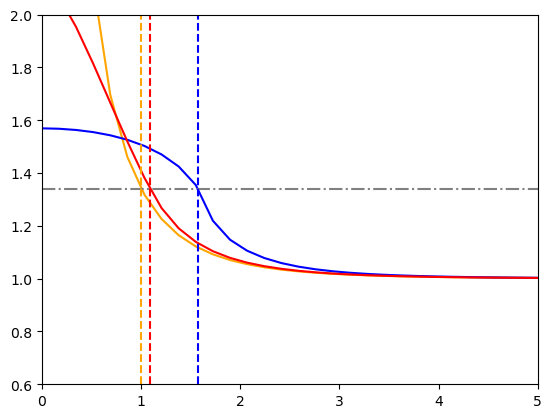

In [ ]:
plt.plot(us, mags_point, color='orange', label='Point')
plt.plot(us, mags_finite, color='blue', label='Finite')
plt.plot(us, mags_finite_wave, color='red', label='Finite + Wave')
plt.axhline(y=A_thresh, color='gray', linestyle='-.')
plt.axvline(x=ut_finite, color='blue', linestyle='--')
plt.axvline(x=ut_finite_wave, color='red', linestyle='--')
plt.axvline(x=1, color='orange', linestyle='--')
plt.xlim(0,5)
plt.ylim(0.6,2.0)
plt.show()

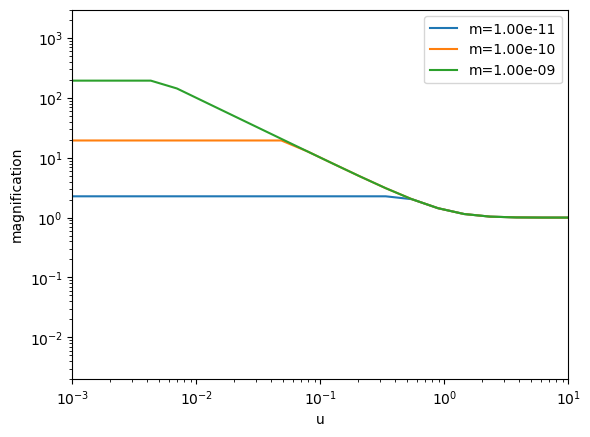

In [ ]:
us = np.logspace(-3,1,20)
for m in np.logspace(-11, -9, 3):
    mags =[magnification_wave(w_func(m, lam), u) for u in us]
    plt.plot(us, mags, label=f'm={m:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('u')
plt.ylabel('magnification')
plt.xlim(1e-3, 1e1)
plt.ylim(2e-3, 3e3)
plt.legend()
plt.show()    

In [ ]:
dls = np.logspace(-2, 2, 30)
uts_finite = [u_t_finite(m_pbh, lam, dl, ds) for dl in dls]

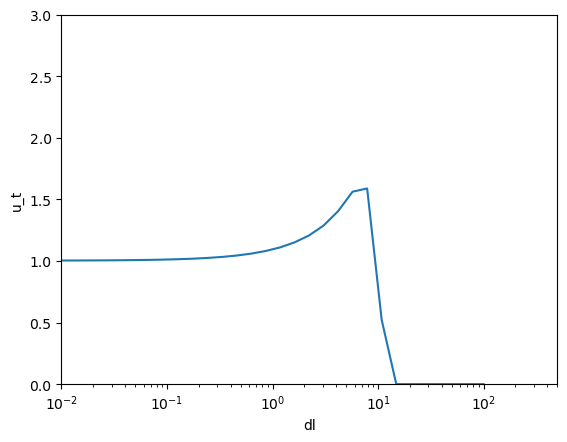

In [ ]:
plt.plot(dls, uts_finite)
plt.xscale('log')
plt.xlim(1e-2, 5e2)
plt.ylim(0,3)
plt.xlabel('dl')
plt.ylabel('u_t')
plt.show()

In [ ]:
us = np.logspace(-3, 1, 20)
rhos = np.array([0.1, 0.5, 1.0])
mags = np.zeros((len(rhos), len(us)))
w = w_func(m_pbh, lam)
integrand = lambda r, theta: integrand_polar(r, theta, w, u)

for i, rho in enumerate(rhos):
    for j, u in enumerate(us):
        result, _ = nquad(integrand, [[0, rho], [0, 2 * pi]])
        # result, _ = quad(lambda r: quad(lambda theta: integrand_polar(r, theta, w, u), 0, 2*pi)[0], 0, rho)
        result = result / (pi * rho**2)
        mags[i,j] = result

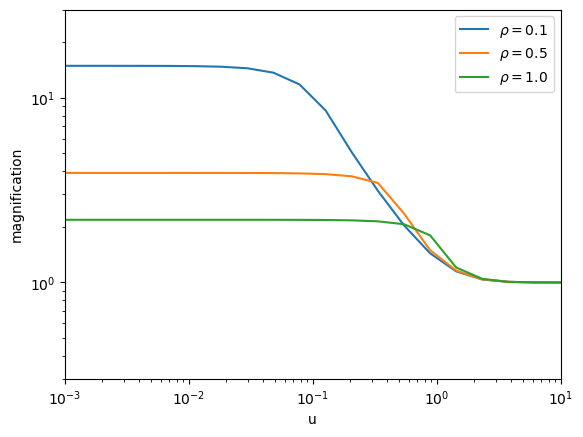

In [ ]:
for i, rho in enumerate(rhos):
    plt.loglog(us, mags[i,:], label=f'$\\rho = {rho}$')
plt.xlabel('u')
plt.ylabel('magnification')
plt.xlim(1e-3, 1e1)
plt.ylim(3e-1, 3e1)
plt.legend()
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()